In [1]:
import pandas as pd
import sqlite3
import joblib
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the trained models
log_model = joblib.load("../Resources/logistic_regression_model.pkl")
tree_model = joblib.load("../Resources/decision_tree_model.pkl")
rf_model = joblib.load("../Resources/random_forest_model.pkl")

print("Models loaded successfully")

Models loaded successfully


In [3]:
# Connect to SQLite database
sqlite_db_path = "../student_performance.db"
conn = sqlite3.connect(sqlite_db_path)
df_mat = pd.read_sql("SELECT * FROM student_mat", conn)
df_por = pd.read_sql("SELECT * FROM student_por", conn)
df = pd.concat([df_mat, df_por], ignore_index=True)
conn.close()

# Display first few rows
print("Sample Data:")
display(df.head())

Sample Data:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [4]:
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

scaler = StandardScaler()
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [5]:
df['sudden_grade_drop'] = df['G1'] - df['G2']
df['attendance_engagement'] = df['absences'] / (df['G1'] + df['G2'] + df['G3'] + 1)
df['low_engagement_flag'] = (df['attendance_engagement'] > df['attendance_engagement'].quantile(0.75)).astype(int)

X_analysis = df.drop(columns=['G3'])

In [6]:
# Predicting
df['Predicted_Performance_Log'] = log_model.predict(X_analysis)
df['Predicted_Performance_Tree'] = tree_model.predict(X_analysis)

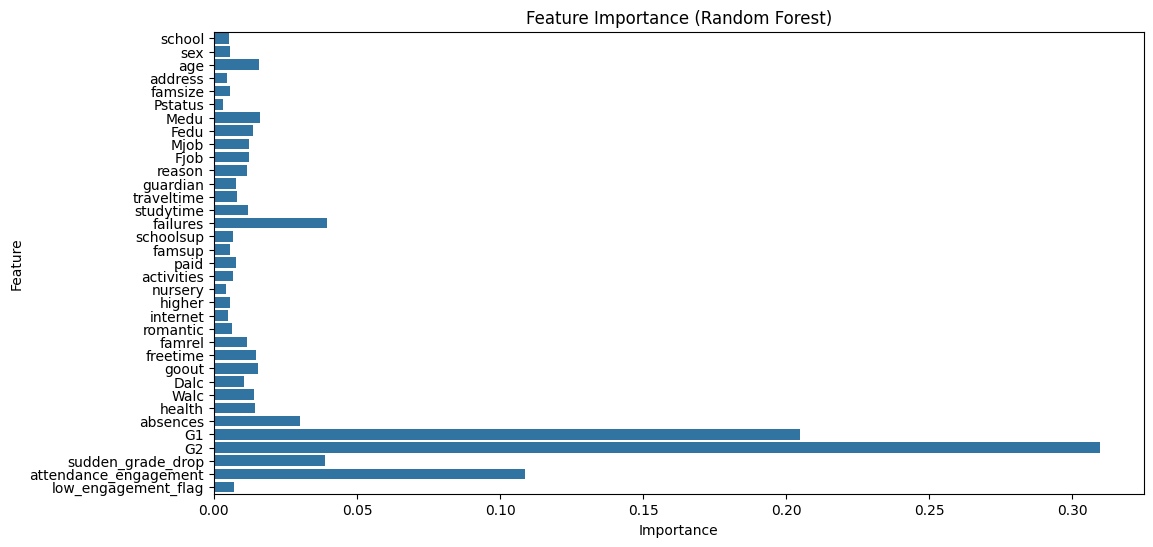

In [7]:
# Feature importance analysis

feature_importance = rf_model.feature_importances_
feature_names = X_analysis.columns

plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importance, y=feature_names)
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [12]:
# comparing social groups by performance

# Undo standard scaling for categorical variables (assuming StandardScaler was used)
df['Dalc'] = (df['Dalc'] * df['Dalc'].std()) + df['Dalc'].mean()
df['Walc'] = (df['Walc'] * df['Walc'].std()) + df['Walc'].mean()
df['romantic'] = (df['romantic'] * df['romantic'].std()) + df['romantic'].mean()

# Convert back to integer categories
df['Dalc'] = df['Dalc'].round().astype(int)
df['Walc'] = df['Walc'].round().astype(int)
df['romantic'] = df['romantic'].round().astype(int)

# Check if predictions have variation
print("Prediction Value Counts:")
print(df['Predicted_Performance_Log'].value_counts())

# Check if categorical variables are in the correct format
print("Categorical Variables Preview:")
print(df[['Dalc', 'Walc', 'romantic']].head())

# Ensure categorical variables are properly formatted
df['Dalc'] = df['Dalc'].astype(int)
df['Walc'] = df['Walc'].astype(int)
df['romantic'] = df['romantic'].astype(int)

# Ensure Predicted_Performance_Log is not empty
if df['Predicted_Performance_Log'].nunique() > 1:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Using a histogram visualization
    axes[0].hist(df['Dalc'], bins=len(df['Dalc'].unique()), weights=df['Predicted_Performance_Log'], alpha=0.7, edgecolor='black')
    axes[0].set_title("Daily Alcohol Consumption vs. Predicted Performance")
    axes[0].set_xlabel("Dalc")
    axes[0].set_ylabel("Predicted Performance")

    axes[1].hist(df['Walc'], bins=len(df['Walc'].unique()), weights=df['Predicted_Performance_Log'], alpha=0.7, edgecolor='black')
    axes[1].set_title("Weekend Alcohol Consumption vs. Predicted Performance")
    axes[1].set_xlabel("Walc")
    axes[1].set_ylabel("Predicted Performance")

    axes[2].hist(df['romantic'], bins=len(df['romantic'].unique()), weights=df['Predicted_Performance_Log'], alpha=0.7, edgecolor='black')
    axes[2].set_title("Romantic Relationships vs. Predicted Performance")
    axes[2].set_xlabel("Romantic")
    axes[2].set_ylabel("Predicted Performance")

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Warning: No variation in predicted performance. Model may need adjustment.")


Prediction Value Counts:
Predicted_Performance_Log
0    1044
Name: count, dtype: int64
Categorical Variables Preview:
   Dalc  Walc  romantic
0     0     0         0
1     0     0         0
2     0     0         0
3     0     0         1
4     0     0         0
⚠️ Warning: No variation in predicted performance. Model may need adjustment.
